In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

import matplotlib.pyplot as plt
import aesara.tensor as at
import scipy.stats as st

from pymc3.math import logsumexp

%matplotlib inline
%config InlineBackend.figure_format = "retina"

You are running the v4 development version of PyMC3 which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc3/tree/v3


In [2]:
with pm.Model() as model:
    test = pm.Normal("test", 0, 1)
    norm = pm.Normal

### Simpler Example

In [3]:
sigma = 2 # known mu for simplicity
sample_sizes = [5, 10, 25, 50, 100, 500, 1000]

posterior_samples = {}

for n in sample_sizes:
    rng = np.random.RandomState(seed=123)
    x = rng.normal(loc=1, scale=sigma, size=[n,])
    
    with pm.Model() as model:
        mu = pm.Normal("mu", mu=0, sigma=5)
        potential = pm.Potential(
            name="potential-test",
            var=pm.Normal.logp(x, mu=mu, sigma=sigma)
        )
        
        print(pm.Normal.logp(x, mu=mu, sigma=sigma).shape.eval())

        trace = pm.sample(
            draws=1000,
            chains=1,
        )
        
        posterior_samples[n] = trace.to_dict()["posterior"]["mu"][0]
        # should tend towards 1 as n increases

[5]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
/Users/larryshamalama/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/arviz/data/inference_data.py:436: UserWarning: The attributes are not same for all groups. Considering only the first group `attrs`
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[10]


Sequential sampling (1 chains in 1 job)
NUTS: [mu]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[25]


Sequential sampling (1 chains in 1 job)
NUTS: [mu]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[50]


Sequential sampling (1 chains in 1 job)
NUTS: [mu]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[100]


Sequential sampling (1 chains in 1 job)
NUTS: [mu]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[500]


Sequential sampling (1 chains in 1 job)
NUTS: [mu]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1000]


Sequential sampling (1 chains in 1 job)
NUTS: [mu]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [4]:
df = pd.DataFrame(posterior_samples)

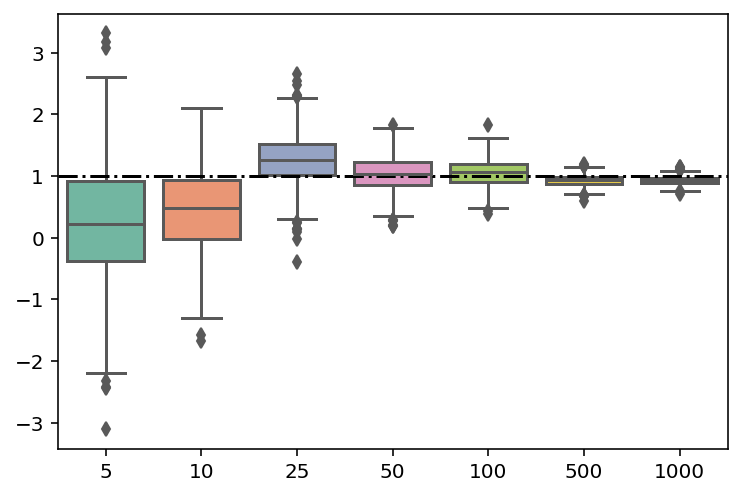

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
sns.boxplot(data=df, palette="Set2")
plt.axhline(y=1, linestyle="-.", c="k")
plt.show()

### Testing `pm.Potential` on Mixture distributions

In [6]:
sunspot_df = pd.read_csv(
    pm.get_data("sunspot.csv"), sep=";", names=["time", "sunspot.year"], usecols=[0, 1]
)

def mixture_logp(weights, comp_dist, atoms, obs):
    # comp_dist is something like lambda obs, atoms: pm.Normal.logp(obs, atoms, 1)

    atoms_shape = atoms.shape
    obs_shape = obs.shape

    try:
        atoms_shape = tuple(atoms_shape.eval())
    except Exception as e:
        atoms_shape = tuple(atoms_shape)

    weights = at.broadcast_to(weights, shape=obs_shape + atoms_shape)
    log_weights = at.log(weights)
    atoms_logp = comp_dist(
        at.broadcast_to(obs, atoms_shape + obs_shape),
        at.broadcast_to(atoms, obs_shape + atoms_shape).T,
    ).T
    
    return at.squeeze(logsumexp(log_weights + atoms_logp, axis=-1))

def stick_breaking(beta):
    portion_remaining = at.concatenate([[1], at.cumprod(1 - beta)[:-1]])

    return beta * portion_remaining

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

Testing `mixture_logp`

In [ ]:
alpha = [1, 1, 1,]; K = 19

weights = np.random.dirichlet(alpha=alpha, size=[]) # placeholder
atoms = np.random.normal(size=[len(alpha),])
observations = np.array([-1, -0.5, 0, 0.5, 1])

mixture_logp(
    weights=weights,
    comp_dist=lambda obs, atoms: pm.Normal.logp(obs, atoms, 1),
    atoms=atoms,
    obs=observations,
).eval()

In [ ]:
K = 50
rng = np.random.RandomState(seed=123) # doesn't work with seed=123, 12, etc.

with pm.Model(rng_seeder=rng) as model:
    α = pm.Gamma('α', 1., 1.)
    β = pm.Beta('β', 1, α, shape=K)
    w = pm.Deterministic('w', stick_breaking(β))
    
    μ = pm.Uniform(
        'μ', 
        0., 
        300., 
        shape=K, 
        transform=pm.transforms.ordered
    )
    comp_ix = pm.Categorical("comp_ix", w, shape=(K,))
    obs = pm.Poisson("obs", μ[comp_ix], observed=x)
                             
#     comp_dist = pm.Poisson.logp # x is data, normally we would use obs=...
#     obs = pm.Potential(
#         "obs",
#         mixture_logp(w, comp_dist, μ, sunspot_df["sunspot.year"].values)
#     )
    
    trace = pm.sample(
        10000,
        cores=2,
        chains=1,
    ) # sometimes needs to rerun due to bad energy...?

In [ ]:
_ = pm.plot_trace(trace)

In [ ]:
x_plot = np.arange(250)

post_pmf_contribs = st.poisson.pmf(np.atleast_3d(x_plot),
                                         trace.to_dict()["posterior"]["μ"][0][:, np.newaxis, :])
post_pmfs = (trace.to_dict()["posterior"]['w'][0][:, np.newaxis, :] * post_pmf_contribs).sum(axis=-1)

post_pmf_low, post_pmf_high = np.percentile(post_pmfs, [2.5, 97.5], axis=0)

fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(sunspot_df['sunspot.year'].values, bins=40, density=True, lw=0, alpha=0.75);

ax.fill_between(x_plot, post_pmf_low, post_pmf_high,
                 color='gray', alpha=0.45)
ax.plot(x_plot, post_pmfs[0],
        c='gray', label='Posterior sample densities');
ax.plot(x_plot, post_pmfs[::200].T, c='gray');
ax.plot(x_plot, post_pmfs.mean(axis=0),
        c='k', label='Posterior expected density');

ax.legend(loc=1);